***<h1>Fake News Detection using Natural Language Processing</h1>***

**<h4>Problem statement</h4>** 
*The proliferation of fake news on social media and the internet is a serious problem with far-reaching social and political consequences. With the massive amount of information shared daily, it becomes difficult for users to differentiate between reliable and misleading news sources. Therefore, an automated machine learning system is needed to help users identify and filter out fake news articles effectively.*

*This project aims to build a Fake News Detection model using Natural Language Processing (NLP) and Machine Learning (ML) techniques. The system preprocesses and analyzes text data from news articles, extracts meaningful features using TF-IDF, and then classifies news as *real* or *fake* using two models - Multinomial Naive Bayes and Support Vector Machine (SVM).*
*Both models are evaluated through cross-validation and hyperparameter tuning (RandomizedSearchCV) to ensure accuracy, robustness, and generalization on unseen data.*

***<h2>Phase 1: Importing required libraries and initial setup***

*This project uses Pandas and NumPy for data handling, and Matplotlib and Seaborn for visualization.
Text preprocessing is done using NLTK, and Regex for cleaning and visualizing text.
Machine learning tasks depend on Scikit-learn, which provides tools for feature extraction (TF-IDF), model building (Naive Bayes, Linear SVM), cross-validation, hyperparameter tuning (RandomizedSearchCV) and performance evaluation.
Warnings is used to suppress system messages.*

In [1]:
# Basic imports
import os
import re
import string
import numpy as np
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# NLP imports
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

In [4]:
# sklearn imports
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

***<h2>Phase 2: Loading the Dataset***
*Loading the Fake News Dataset downloaded from Kaggle that has two seperate CSVs - True.csv and Fake.csv for true and fake news data respectively.*

In [5]:
true_path = 'True.csv'
fake_path = 'Fake.csv'

if not os.path.exists(true_path) or not os.path.exists(fake_path):
    raise FileNotFoundError("Make sure 'True.csv' and 'Fake.csv' exist in the working directory.")

true_df = pd.read_csv(true_path)
fake_df = pd.read_csv(fake_path)

# Dataset Shape
print('True shape:', true_df.shape)
print('Fake shape:', fake_df.shape)

# Checking column names in dataset 
print('\nColumns in true.csv:', list(true_df.columns))
print('Columns in fake.csv:', list(fake_df.columns))

True shape: (21417, 4)
Fake shape: (23481, 4)

Columns in true.csv: ['title', 'text', 'subject', 'date']
Columns in fake.csv: ['title', 'text', 'subject', 'date']


***<h2>Phase 3: Prepare and Concatenate Data***
*Combine both datasets into one DataFrame, labeling them as “TRUE” and “FAKE”.*

In [6]:
# Prepare the DataFrames to concatenate
true_news = pd.DataFrame({
    'text':true_df['title'].astype(str) + ' ' + true_df['text'].astype(str),
    'label': 'TRUE' # TRUE for real news
})

fake_news = pd.DataFrame({
    'text': fake_df['title'].astype(str) + ' ' + fake_df['text'].astype(str),
    'label': 'FAKE' # FAKE for fake news
})

# Concatenate
data = pd.concat([true_news, fake_news], axis=0).reset_index(drop=True)

# Shuffle
data = data.sample(frac=1, random_state=42).reset_index(drop=True)
print('Combined shape:', data.shape)

Combined shape: (44898, 2)


In [7]:
data.head()

,text,label
0,BREAKING: GOP Chairman Grassley Has Had Enoug...,FAKE
1,Failed GOP Candidates Remembered In Hilarious...,FAKE
2,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,FAKE
3,California AG pledges to defend birth control ...,TRUE
4,AZ RANCHERS Living On US-Mexico Border Destroy...,FAKE


In [8]:
data.tail(3)

,text,label
44895,ATHEISTS SUE GOVERNOR OF TEXAS Over Display on...,FAKE
44896,Republican tax plan would deal financial hit t...,TRUE
44897,U.N. refugee commissioner says Australia must ...,TRUE


***<h2>Phase 4: Exploratory Data Analysis (EDA)***

*Perform basic analysis to understand sample texts, class balance, and label distribution.*

In [9]:
#Showing some sample texts
print('Sample real news (label TRUE):')
print(data[data['label'] == 'TRUE']['text'].iloc[0][:400])
print('\nSample fake news (label FAKE):')
print(data[data['label'] == 'FAKE']['text'].iloc[0][:400])
print("\n")

Sample real news (label TRUE):
California AG pledges to defend birth control insurance coverage SAN FRANCISCO (Reuters) - California Attorney General Xavier Becerra said on Friday he was “prepared to take whatever action it takes” to defend the Obamacare mandate that health insurers provide birth control, now that the Trump administration has moved to circumvent it. The administration’s new contraception exemptions “are another

Sample fake news (label FAKE):
 BREAKING: GOP Chairman Grassley Has Had Enough, DEMANDS Trump Jr. Testimony Donald Trump s White House is in chaos, and they are trying to cover it up. Their Russia problems are mounting by the hour, and they refuse to acknowledge that there are problems surrounding all of this. To them, it s  fake news,  or a  hoax.  However, the facts bear things out differently, and it seems that there are now




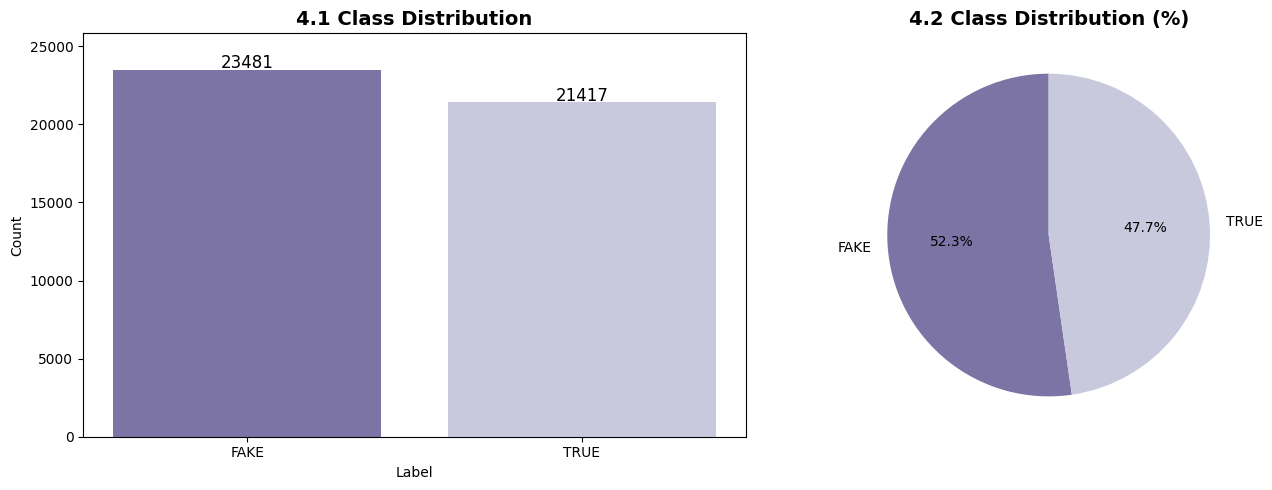


Label Balance:
  FAKE: 23481 (52.30%)
  TRUE: 21417 (47.70%)


In [10]:
# Class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
label_counts = data['label'].value_counts()
axes[0].bar(label_counts.index, label_counts.values, color=['#7B74A4', '#C8C9DD'])
axes[0].set_title('4.1 Class Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Count')
axes[0].set_ylim(0, label_counts.max() * 1.1)
for i, (label, count) in enumerate(label_counts.items()):
    axes[0].text(i, count + 100, str(count), ha='center', fontsize=12)

# Percentage
axes[1].pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%',
            colors=['#7B74A4', '#C8C9DD'], startangle=90)
axes[1].set_title('4.2 Class Distribution (%)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nLabel Balance:")
for label, count in label_counts.items():
    print(f"  {label}: {count} ({count/len(data)*100:.2f}%)")

*The count plot shows that the dataset is fairly balanced.  
This balance ensures that the models will not be biased toward any one class and will learn to classify both categories effectively.*

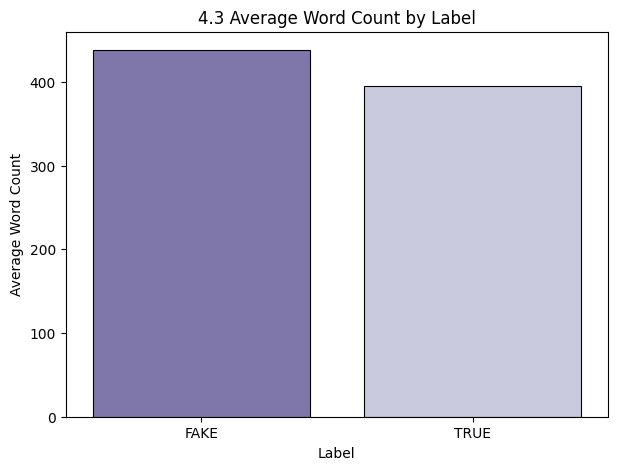

In [11]:
data['text_len'] = data['text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(7,5))
sns.barplot(data.groupby('label')['text_len'].mean(),palette='Purples_r',edgecolor='black',linewidth=0.8)
plt.title("4.3 Average Word Count by Label")
plt.xlabel("Label")
plt.ylabel("Average Word Count")
plt.show()

*The bar chart shows that fake news articles are slightly longer on average (400+ words) than real news articles (<400 words).  
This indicates that fake news may use more descriptive or exaggerated text to appear credible.  
However, since the difference is small, text length alone is not a reliable feature, so deeper text analysis using TF-IDF and ML models is required.*

***<h2>Phase 5: Text Preprocessing***
*The below cell handles text preprocessing and cleaning. It converts all text to lowercase, removes URLs, removes non-alphabetic characters, tokenize and filters out stopwords to keep the meaningful words. Lemmatization is then applied to reduce words to their root forms. The cleaned and preprocessed text is stored into a ‘clean_text’ column for further analysis.*

In [12]:
# Preprocessing functions
stop_words = set(stopwords.words('english'))
porter = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def clean_text(text, do_stem=False, do_lemma=True):
    text = str(text).lower()   # convert text to lowercase
    text = re.sub(r'http\S+|www\.\S+', ' ', text)   # removes URLs
    text = re.sub(r'<.*?>', ' ', text)   # removes HTML tags
    text = text.translate(str.maketrans('', '', string.punctuation))   # removes punctuation
    text = re.sub(r'\d+', ' ', text)   # remove numbers
    tokens = text.split()   # tokenize (simple split)
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]   # remove stopwords and short tokens

    if do_stem:
        tokens = [porter.stem(t) for t in tokens]
    elif do_lemma:
        tokens = [lemmatizer.lemmatize(t) for t in tokens]

    return ' '.join(tokens)

In [13]:
# Quick test on one sample 
print('Original:\n', data['text'].iloc[1][:200])
print('\nCleaned:\n', clean_text(data['text'].iloc[1])[:200])

Original:
  Failed GOP Candidates Remembered In Hilarious Mocking Eulogies (VIDEO) Now that Donald Trump is the presumptive GOP nominee, it s time to remember all those other candidates who tried so hard to beat

Cleaned:
 failed gop candidate remembered hilarious mocking eulogy video donald trump presumptive gop nominee time remember candidate tried hard beat race white house forget misstep gaffe weirdness sheer idiocy


In [14]:
# Apply cleaning to the dataset 
tqdm.pandas(desc="Cleaning text")
data['clean_text'] = data['text'].progress_apply(lambda x: clean_text(x, do_stem=False, do_lemma=True))

# Drop rows where cleaning produced empty text 
empty_rows_count = (data['clean_text'].str.strip() == '').sum()
print(f"\nEmpty cleaned texts: {empty_rows_count}")
if empty_rows_count > 0:
    data = data[~(data['clean_text'].str.strip() == '')].reset_index(drop=True)
    print('Dropped empty cleaned-text rows. New shape:', data.shape)

Cleaning text: 100%|██████████| 44898/44898 [01:37<00:00, 458.46it/s]



Empty cleaned texts: 9
Dropped empty cleaned-text rows. New shape: (44889, 4)


In [15]:
data.head(3)

,text,label,text_len,clean_text
0,BREAKING: GOP Chairman Grassley Has Had Enoug...,FAKE,372,breaking gop chairman grassley enough demand t...
1,Failed GOP Candidates Remembered In Hilarious...,FAKE,504,failed gop candidate remembered hilarious mock...
2,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,FAKE,393,mike pence’s new neighbor hilariously trolling...


***<h2>Phase 6: Data Splitting***

*The dataset is divided into training and testing sets before vectorising to prevent data leakage.*

In [16]:
# Train-test split
X = data['clean_text']
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)
print('Train size:', X_train.shape[0], '\nTest size:', X_test.shape[0])

Train size: 35911 
Test size: 8978


***<h2>Phase 7: Model Building – Pipeline Creation and Feature Extraction***

*Pipelines are built for Multinomial Naive Bayes (NB) and Linear Support Vector Machine (SVM) models.
NB is efficient for text classification with word frequency features, while SVM performs well in high-dimensional spaces typical of TF-IDF data.
Each pipeline integrates TF-IDF vectorization for feature extraction and the respective classifier for prediction.*

In [17]:
# Two pipelines: TF-IDF + MultinomialNB, TF-IDF + LinearSVC
pipe_nb = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB()),
])

pipe_svm = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LinearSVC()),
])

***<h2>Phase 8: Cross-Validation***

*Cross-validation is used to estimate model performance and prevent overfitting.
Each pipeline is evaluated using k-fold (5-fold) cross-validation on the training data.
This ensures both models will generalize well before hyperparameter tuning and final evaluation.*

In [18]:
print('Cross-validation scores (accuracy) for 5-folds:')
cv_scores_nb = cross_val_score(pipe_nb, X_train, y_train, cv=5, scoring='accuracy')
cv_scores_svm = cross_val_score(pipe_svm, X_train, y_train, cv=5, scoring='accuracy')
print('NB CV accuracy:', np.round(cv_scores_nb.mean(), 4), '±', np.round(cv_scores_nb.std(),4))
print('SVM CV accuracy:', np.round(cv_scores_svm.mean(), 4), '±', np.round(cv_scores_svm.std(),4))

Cross-validation scores (accuracy) for 5-folds:
NB CV accuracy: 0.9441 ± 0.0023
SVM CV accuracy: 0.9951 ± 0.0007


***<h2>Phase 9: Hyperparameter Tuning (RandomizedSearchCV)***

*Model and vectorizer parameters are optimized using RandomizedSearchCV to improve performance.*  
*This process tunes both TF-IDF parameters and classifier hyperparameters simultaneously.*  
*Example parameters tuned:*  
*TF-IDF: max_df, min_df, ngram_range, stop_words*  
*Naive Bayes: alpha*  
*SVM: C*  
*In this phase, the model is trained multiple times with different parameter combinations using cross-validation.*  
*The combination that gives the best validation score is selected, ensuring the model has the most suitable feature extraction and parameter settings for evaluation.*

In [19]:
print("Hyperparameter tuning using RandomizedSearchCV...")

param_dist_nb = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__max_df': [0.9, 0.95],
    'clf__alpha': [0.5, 1.0]
}

param_dist_svm = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__max_df': [0.9, 0.95],
    'clf__C': [0.5, 1.0]
}

rand_nb = RandomizedSearchCV(pipe_nb, param_dist_nb, cv=3, n_iter=3, n_jobs=-1, scoring='f1_weighted', random_state=42, verbose=1)

rand_svm = RandomizedSearchCV(pipe_svm, param_dist_svm, cv=3, n_iter=3, n_jobs=-1, scoring='f1_weighted', random_state=42, verbose=1)

print("\nRunning RandomizedSearchCV for NB...")
rand_nb.fit(X_train, y_train)
print("Best NB params:", rand_nb.best_params_)
print("Best NB CV f1_weighted:", rand_nb.best_score_)

print("\nRunning RandomizedSearchCV for SVM...")
rand_svm.fit(X_train, y_train)
print("Best SVM params:", rand_svm.best_params_)
print("Best SVM CV f1_weighted:", rand_svm.best_score_)

best_nb = rand_nb.best_estimator_
best_svm = rand_svm.best_estimator_

Hyperparameter tuning using RandomizedSearchCV...

Running RandomizedSearchCV for NB...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best NB params: {'tfidf__ngram_range': (1, 2), 'tfidf__max_df': 0.9, 'clf__alpha': 0.5}
Best NB CV f1_weighted: 0.9637827429366109

Running RandomizedSearchCV for SVM...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best SVM params: {'tfidf__ngram_range': (1, 1), 'tfidf__max_df': 0.9, 'clf__C': 0.5}
Best SVM CV f1_weighted: 0.9935402068231328


***<h2>Phase 10: Model Testing and Evaluation***

*The optimized pipelines are trained on the training set and evaluated on the test set.*  
*Metrics such as accuracy, precision, recall, F1-score, and the confusion matrix are used to assess model performance and generalization capability.*


=== MultinomialNB (Test set) ===
Accuracy: 0.9692581866785476
              precision    recall  f1-score   support

        FAKE     0.9779    0.9629    0.9704      4695
        TRUE     0.9600    0.9762    0.9680      4283

    accuracy                         0.9693      8978
   macro avg     0.9690    0.9696    0.9692      8978
weighted avg     0.9694    0.9693    0.9693      8978



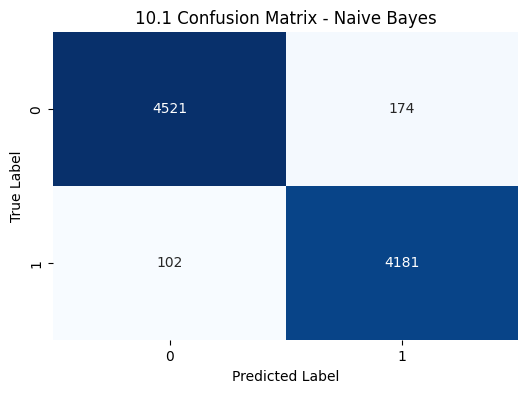


=== LinearSVC (Test set) ===
Accuracy: 0.9958788148808198
              precision    recall  f1-score   support

        FAKE     0.9964    0.9957    0.9961      4695
        TRUE     0.9953    0.9960    0.9957      4283

    accuracy                         0.9959      8978
   macro avg     0.9959    0.9959    0.9959      8978
weighted avg     0.9959    0.9959    0.9959      8978



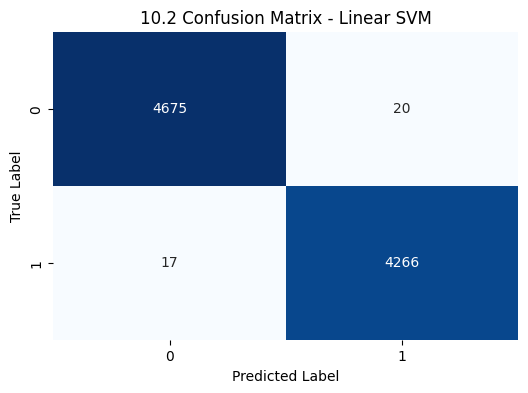

In [20]:
# 9. Evaluate on test set
best_nb = rand_nb.best_estimator_
best_svm = rand_svm.best_estimator_

# Predict
nb_pred = best_nb.predict(X_test)
svm_pred = best_svm.predict(X_test)

print('\n=== MultinomialNB (Test set) ===')
print('Accuracy:', accuracy_score(y_test, nb_pred))
print(classification_report(y_test, nb_pred, digits=4))
cm_nb = confusion_matrix(y_test, nb_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("10.1 Confusion Matrix - Naive Bayes")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('\n=== LinearSVC (Test set) ===')
print('Accuracy:', accuracy_score(y_test, svm_pred))
print(classification_report(y_test, svm_pred, digits=4))
cm_svm = confusion_matrix(y_test, svm_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("10.2 Confusion Matrix - Linear SVM")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

***<h2>Phase 11: Model Comparison***

*The results from both classifiers are compared to identify the better-performing model.*

In [21]:
# Comparison and simple insights
nb_f1 = f1_score(y_test, nb_pred, average='weighted')
svm_f1 = f1_score(y_test, svm_pred, average='weighted')

print('Comparison (Test set F1 scores):')
print('NB F1:', round(nb_f1,4))
print('SVM F1:', round(svm_f1,4))

if nb_f1 > svm_f1:
    print('\nConclusion: MultinomialNB performed slightly better on the test F1 score.\n')
elif svm_f1 > nb_f1:
    print('\nConclusion: LinearSVC performed slightly better on the test F1 score.\n')
else:
    print('\nConclusion: Both models performed similarly.\n')

Comparison (Test set F1 scores):
NB F1: 0.9693
SVM F1: 0.9959

Conclusion: LinearSVC performed slightly better on the test F1 score.



*<h3>Checking the Actual vs Predicted Labels for the Best Model on the Test Set*

In [22]:
# Combine text, true label, and predicted label into a DataFrame
results = pd.DataFrame({
    'Text': X_test,
    'Actual Label': y_test,
    'Predicted Label': svm_pred
})

# first 5 predictions
print("Head - first 5 predictions")
display(results.head())

# last 5 predictions
print("Tail - last 5 predictions")
display(results.tail())

Head - first 5 predictions


,Text,Actual Label,Predicted Label
36443,penny revives talk moving tel aviv embassy jer...,TRUE,TRUE
2586,suspends official travel myanmar troubled rakh...,TRUE,TRUE
28319,cnn went trump latest meltdown unbelievably br...,FAKE,FAKE
2401,former business partner predicts prison trump ...,FAKE,FAKE
29420,exclusive stopped philippine rifle sale senato...,TRUE,TRUE


Tail - last 5 predictions


,Text,Actual Label,Predicted Label
31667,trump administration say trading partner manip...,TRUE,TRUE
39988,college student tell london mayor ps racist re...,FAKE,FAKE
1223,philippine tie back track trump duterte make b...,TRUE,TRUE
42913,muhammad ali detained airport right testifying...,FAKE,FAKE
6674,trump make daughter ivanka fill he’s ‘exhauste...,FAKE,FAKE


***<h2>Phase 12: Saving the Final Model***
*The best-performing pipeline (including the trained TF-IDF vectorizer and classifier) is saved using joblib for future predictions without retraining.*

In [23]:
# Save pipelines using joblib to reuse the trained pipeline in future.
import joblib
joblib.dump(best_nb, 'best_nb_pipeline.joblib')
joblib.dump(best_svm, 'best_svm_pipeline.joblib')
print('Saved best pipelines with name: best_nb_pipeline.joblib and best_svm_pipeline.joblib')

# Saving the best-performing model as a .pkl file
joblib.dump(best_svm, "best_model.pkl")
print("Best model saved successfully as best_model.pkl")

Saved best pipelines with name: best_nb_pipeline.joblib and best_svm_pipeline.joblib
Best model saved successfully as best_model.pkl


***<h2>Summary:***
- *Naive Bayes achieved 96% accuracy - it is fast, simple, and has good baseline*
- *SVM achieved 99.5% accuracy and has better generalization*
- *The final model chosen: SVM*
- *Both models were validated with cross-validation and tuned with RandomSearchCV.*
- *The model can be deployed using saved pickle files for future predictions.*

## Sample Predictions

In [24]:
samples = [
    "Scientists claim eating chocolate cures all diseases overnight!",
    "Donald Trump is the current President of US",
    "Drinking lemon juice cures Covid-19 infection."]
for text in samples:
    print(f"Text: {text}\nPredicted Label: {best_svm.predict([text])[0]}\n")

Text: Scientists claim eating chocolate cures all diseases overnight!
Predicted Label: FAKE

Text: Donald Trump is the current President of US
Predicted Label: TRUE

Text: Drinking lemon juice cures Covid-19 infection.
Predicted Label: FAKE

